In [36]:
from datasets import load_dataset
import random
import string
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Whitespace
import torch.nn as nn
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [37]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/deyuq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/deyuq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
emotions = load_dataset("dair-ai/emotion")

In [39]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [40]:
train_data = emotions["train"]
validation_data = emotions["validation"]
test_data = emotions["test"]

In [41]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [42]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/deyuq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [43]:
train_data["text"]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i feel like i have to make the suffering i m seeing mean something',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel low energy i m just thirst

In [44]:
oversample = RandomOverSampler()
train_text_oversample, train_data_oversample = oversample.fit_resample(np.array(train_data["text"]).reshape(-1,1), train_data["label"])
train_text_oversample

array([['i didnt feel humiliated'],
       ['i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
       ['im grabbing a minute to post i feel greedy wrong'],
       ...,
       ['i personally feel amazed that i have managed to connect with such amazingly talented and creative people through this little world of dance'],
       ['i feel the tug of the fabric against my thighs and butt i am overwhelmed with the feeling that i am just too fat'],
       ['im feeling overwhelmed']], shape=(32172, 1), dtype='<U300')

In [45]:
train_text_oversample = train_text_oversample.flatten()
len(train_text_oversample)

32172

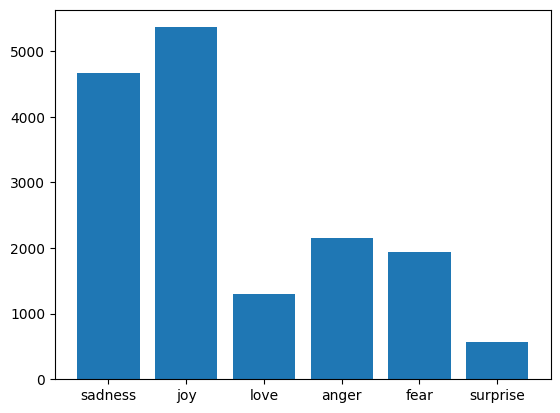

In [46]:
label_count = Counter(train_data["label"])
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

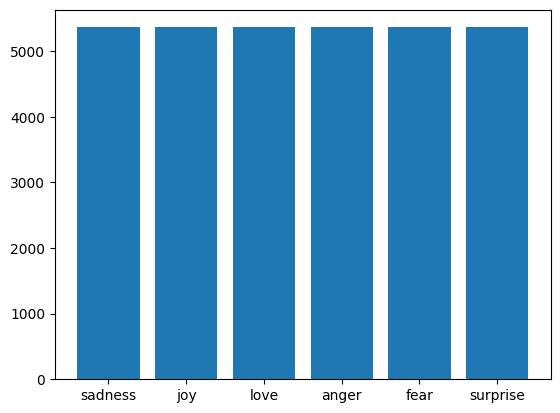

In [47]:
label_count = Counter(train_data_oversample)
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

In [48]:
# Tokenization
vocab_n = 5000
sequence_len = 64

# Initialize a tokenizer using BPE (Byte Pair Encoding)
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(length=sequence_len)
tokenizer.enable_truncation(max_length=sequence_len)
tokenizer_trainer = trainers.BpeTrainer(vocab_size=vocab_n)
tokenizer.train_from_iterator(train_text_oversample, trainer=tokenizer_trainer)

In [49]:
def preprocess_text(text: str, tokenizer: Tokenizer):
    """ 
    Helper function to tokenize text and return corresponding token IDs as tensors.

    Args:
        text, str: Text instance from training data.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        Tensor: One-dimensional PyTorch tensor with token IDs.
    """
    return torch.tensor(tokenizer.encode(text).ids)


def preprocess_label(label: int):
    """ 
    Helper function to return label as tensor.

    Args:
        label, int: Label from instance.
    Returns:
        Tensor: One-dimensional PyTorch tensor containing the label index.
    """
    return torch.tensor(label)


def preprocess(data: list, labels: list, tokenizer: Tokenizer):
    """ 
    Transforms input dataset to tokenized vector representations.

    Args:
        data, dict: Dictionary with text instances and labels.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        list: List with tensors for the input texts and labels.
    """
    instances = []

    for text, label in zip(data, labels):
        input = preprocess_text(text, tokenizer)
        label = preprocess_label(label)
        
        instances.append((input, label))

    return instances

In [50]:
train_instances = preprocess(train_text_oversample, train_data_oversample, tokenizer)
val_instances = preprocess(validation_data["text"], validation_data["label"], tokenizer)
test_instances = preprocess(test_data["text"], test_data["label"], tokenizer)

In [51]:
# Batching

def batching(instances: list, batch_size: int, shuffle: bool):
    """ 
    Batches input instances along the given size and returns list of batches.

    Args:
        instances, list: List of instances, containing a tuple of two tensors 
            for each text as well as corresponding label.
        batch_size, int: Size for batches.
        shuffle, bool: If true, the instances will be shuffled before batching.
    Returns:
        list: List containing tuples that correspond to single batches.
    """
    if shuffle:
        random.shuffle(instances)

    batches = []

    # We iterate through the instances with batch_size steps
    for i in range(0, len(instances), batch_size):

        # Stacking the instances with dim=0 (default value)
        batch_texts = torch.stack(
            [instance[0] for instance in instances[i : i + batch_size]]
        )
        batch_labels = torch.stack(
            [instance[1] for instance in instances[i : i + batch_size]]
        )

        batches.append((batch_texts, batch_labels))
    
    return batches

In [54]:
# CNN Network

class CNN_Classifier(nn.Module):
    """ 
    CNN for sentiment classification with 6 classes, consisting of an embedding 
    layer, two convolutional layers with different filter sizes, different 
    pooling sizes, as well as one linear output layer.
    """
    def __init__(self):
        super().__init__()
        # We can implement embeddings as a simple lookup-table for given word 
        # indices
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), 300)

        # One-dimensional convolution-layer with 300 input channels, and 100  
        # output channels as well as kernel size of 3; note that the
        # one-dimensional convolutional layer has 3 dimensions
        self.conv_1 = nn.Conv1d(300, 100, 3, padding="same")

        # Pooling with with a one-dimensional sliding window of length 3, 
        # reducing in this fashion the sequence length 
        self.pool_1 = nn.MaxPool1d(3)

        # The input will be the reduced number of maximum picks from the
        # previous operation; the dimension of those picks is the same as the
        # output channel size from self.conv_1. We apply a different filter of 
        # size 5.
        self.conv_2 = nn.Conv1d(100, 50, 5, padding="same")

        # Pooling with window size of 5
        self.pool_2 = nn.MaxPool1d(5)

        # Final fully connected linear layer from the 50 output channels to the
        # 6 sentiment categories 
        self.linear_layer = nn.Linear(50, 6)

    def forward(self, x):
        """ 
        Defining the forward pass of an input batch x.

        Args:
            x, tensor: The input is a batch of tweets from the data.
        Returns:
            y, float: The output are the logits from the final layer.
        """
        # x will correspond here to a batch; therefore, the input dimensions of 
        # the embedding will be by PyTorch convention as follows:
        # [batch_size, seq_len, emb_dim]
        x = self.embedding(x)

        # Unfortunately the embedding tensor does not correspond to the shape 
        # that is needed for nn.Conv1d(); for this reason, we must switch its 
        # order to [batch_size, emb_dim, seq_len] for PyTorch
        x = x.permute(0, 2, 1)

        # We can wrap the ReLu activation function around our convolution layer
        # The output tensor will have the following shape: 
        # [batch_size, 100, seq_len]
        x = nn.functional.relu(self.conv_1(x))

        # Applying max pooling of size 3 means that the output length of the 
        # sequence is shrunk to seq_len//3
        x = self.pool_1(x)

        # Output of the following layer: [batch_size, 50, seq_len//3]
        x = nn.functional.relu(self.conv_2(x))

        # Shrinking the sequence length by 5
        x = self.pool_2(x)
        # print(x.shape)

        # At this point we have a tensor with 3 dimensions; however, the final layer 
        # requires an input of size [batch_size x 50]. To get this value we can 
        # aggregate the values and continue only with their mean
        x = x.mean(dim=-1)

        # In this fasion, the linear layer can be used to make predictions
        y = self.linear_layer(x)

        return y
    
    def fit(self, train_instances, val_instances, epochs, batch_size):
        """ 
        Gradient based fitting method with Adam optimization and automatic 
        evaluation (F1 score) for each epoch.

        Args:
            train_instances, list: List of instance tuples.
            val_instances, list: List of instance tuples.
            epochs, int: Number of training epochs.
            batch_size, int: Number of batch size.
        """
        self.train()
        optimizer = torch.optim.Adam(self.parameters())

        for epoch in range(epochs):
            train_batches = batching(
                train_instances,
                batch_size=batch_size,
                shuffle=True)
            
            for inputs, labels in tqdm(train_batches):
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = nn.functional.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
            
            train_f1 = self.evaluate2(train_instances, batch_size=batch_size)
            val_f1 = self.evaluate2(val_instances, batch_size=batch_size)

            print(f"Epoch {epoch + 1} train F1 score: {train_f1}, validation F1 score: {val_f1}")

    def predict(self, input):
        """ 
        To make inferences from the model.

        Args:
            input, tensor: Single instance.
        Returns:
            int: Integer for most probable class.
        """
        self.eval()
        outputs = self(input)

        return torch.argmax(outputs, dim=-1)

    def evaluate(self, instances, batch_size):
        """ 
        To evaluate model's performance by various processes/standard.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        y_test = []
        y_pred = []

        for inputs, labels in batches:
            y_test.extend(labels)
            y_pred.extend(self.predict(inputs))

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print("CNN Classifier:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")

    def evaluate2(self, instances, batch_size):
        """ 
        To make evaluations against the gold standard (true labels) from the 
        data.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        true = []
        pred = []

        for inputs, labels in batches:
            true.extend(labels)
            pred.extend(self.predict(inputs))

        return f1_score(true, pred, average="macro")

In [55]:
classifier = CNN_Classifier()
classifier.fit(train_instances, val_instances, epochs=50, batch_size=16)

100%|██████████| 2011/2011 [00:07<00:00, 259.41it/s]


Epoch 1 train F1 score: 0.961530020007018, validation F1 score: 0.8505455730676612


100%|██████████| 2011/2011 [00:07<00:00, 254.83it/s]


Epoch 2 train F1 score: 0.9868704660678591, validation F1 score: 0.8650939691800307


100%|██████████| 2011/2011 [00:07<00:00, 251.99it/s]


Epoch 3 train F1 score: 0.9875684427895516, validation F1 score: 0.8714413450585141


100%|██████████| 2011/2011 [00:07<00:00, 266.68it/s]


Epoch 4 train F1 score: 0.9942812542355925, validation F1 score: 0.861658795905933


100%|██████████| 2011/2011 [00:07<00:00, 262.04it/s]


Epoch 5 train F1 score: 0.9935640224145192, validation F1 score: 0.8676770932901056


100%|██████████| 2011/2011 [00:07<00:00, 262.71it/s]


Epoch 6 train F1 score: 0.9940329535907405, validation F1 score: 0.8635573994820734


100%|██████████| 2011/2011 [00:07<00:00, 261.32it/s]


Epoch 7 train F1 score: 0.9964568379655887, validation F1 score: 0.8679613323476469


100%|██████████| 2011/2011 [00:07<00:00, 263.67it/s]


Epoch 8 train F1 score: 0.9958971530991825, validation F1 score: 0.8621716250303327


100%|██████████| 2011/2011 [00:07<00:00, 260.69it/s]


Epoch 9 train F1 score: 0.9968613684748066, validation F1 score: 0.8723386271252318


100%|██████████| 2011/2011 [00:07<00:00, 264.01it/s]


Epoch 10 train F1 score: 0.995022369586949, validation F1 score: 0.8526422993663821


100%|██████████| 2011/2011 [00:07<00:00, 263.49it/s]


Epoch 11 train F1 score: 0.9968601591537989, validation F1 score: 0.8685411198889196


100%|██████████| 2011/2011 [00:07<00:00, 256.14it/s]


Epoch 12 train F1 score: 0.9904146264659904, validation F1 score: 0.8551119115449334


100%|██████████| 2011/2011 [00:07<00:00, 262.09it/s]


Epoch 13 train F1 score: 0.9973572232563206, validation F1 score: 0.8610482324023248


100%|██████████| 2011/2011 [00:07<00:00, 264.93it/s]


Epoch 14 train F1 score: 0.9980100508735914, validation F1 score: 0.8471086591419926


100%|██████████| 2011/2011 [00:07<00:00, 262.17it/s]


Epoch 15 train F1 score: 0.9975438029565199, validation F1 score: 0.8552963216886279


100%|██████████| 2011/2011 [00:07<00:00, 263.03it/s]


Epoch 16 train F1 score: 0.9971076853143644, validation F1 score: 0.8552980055105301


100%|██████████| 2011/2011 [00:07<00:00, 263.66it/s]


Epoch 17 train F1 score: 0.9968599755681754, validation F1 score: 0.859309522112547


100%|██████████| 2011/2011 [00:07<00:00, 256.72it/s]


Epoch 18 train F1 score: 0.9950552963866849, validation F1 score: 0.8584447665958127


100%|██████████| 2011/2011 [00:07<00:00, 263.75it/s]


Epoch 19 train F1 score: 0.9984145044466222, validation F1 score: 0.8643231942500543


100%|██████████| 2011/2011 [00:07<00:00, 261.24it/s]


Epoch 20 train F1 score: 0.9984458603189678, validation F1 score: 0.8653037080001958


100%|██████████| 2011/2011 [00:07<00:00, 266.01it/s]


Epoch 21 train F1 score: 0.9977608394863015, validation F1 score: 0.8558245209204051


100%|██████████| 2011/2011 [00:07<00:00, 260.95it/s]


Epoch 22 train F1 score: 0.9981662453272723, validation F1 score: 0.8613203303113229


100%|██████████| 2011/2011 [00:07<00:00, 258.22it/s]


Epoch 23 train F1 score: 0.9977621110114764, validation F1 score: 0.8600529746213915


100%|██████████| 2011/2011 [00:07<00:00, 259.19it/s]


Epoch 24 train F1 score: 0.9985699800909855, validation F1 score: 0.861034836264484


100%|██████████| 2011/2011 [00:07<00:00, 262.12it/s]


Epoch 25 train F1 score: 0.9985075688341171, validation F1 score: 0.8613129254525274


100%|██████████| 2011/2011 [00:07<00:00, 259.76it/s]


Epoch 26 train F1 score: 0.9929719070792374, validation F1 score: 0.8485765128865473


100%|██████████| 2011/2011 [00:07<00:00, 256.06it/s]


Epoch 27 train F1 score: 0.9975443651856816, validation F1 score: 0.8505954245894244


100%|██████████| 2011/2011 [00:07<00:00, 255.41it/s]


Epoch 28 train F1 score: 0.9981972352152294, validation F1 score: 0.8493564444133012


100%|██████████| 2011/2011 [00:07<00:00, 257.69it/s]


Epoch 29 train F1 score: 0.9985701368647047, validation F1 score: 0.8448113098899448


100%|██████████| 2011/2011 [00:07<00:00, 254.49it/s]


Epoch 30 train F1 score: 0.9914481343961676, validation F1 score: 0.8468496502460305


100%|██████████| 2011/2011 [00:07<00:00, 259.66it/s]


Epoch 31 train F1 score: 0.9983212213536586, validation F1 score: 0.8590584061774358


100%|██████████| 2011/2011 [00:08<00:00, 249.62it/s]


Epoch 32 train F1 score: 0.9983211399017656, validation F1 score: 0.8532997160650514


100%|██████████| 2011/2011 [00:07<00:00, 256.87it/s]


Epoch 33 train F1 score: 0.9983837095625495, validation F1 score: 0.8570938921588053


100%|██████████| 2011/2011 [00:07<00:00, 261.09it/s]


Epoch 34 train F1 score: 0.9944420388346055, validation F1 score: 0.8614478489034579


100%|██████████| 2011/2011 [00:07<00:00, 254.53it/s]


Epoch 35 train F1 score: 0.9980716651417653, validation F1 score: 0.8711145896346597


100%|██████████| 2011/2011 [00:07<00:00, 256.59it/s]


Epoch 36 train F1 score: 0.9980415561154808, validation F1 score: 0.8628062808048469


100%|██████████| 2011/2011 [00:07<00:00, 258.23it/s]


Epoch 37 train F1 score: 0.9985390803935442, validation F1 score: 0.8559497970748507


100%|██████████| 2011/2011 [00:07<00:00, 253.42it/s]


Epoch 38 train F1 score: 0.9983524292283631, validation F1 score: 0.8571985684991473


100%|██████████| 2011/2011 [00:07<00:00, 256.71it/s]


Epoch 39 train F1 score: 0.9968294545617629, validation F1 score: 0.8474814982680196


100%|██████████| 2011/2011 [00:07<00:00, 257.01it/s]


Epoch 40 train F1 score: 0.9971720807818127, validation F1 score: 0.8722332306553279


100%|██████████| 2011/2011 [00:07<00:00, 255.21it/s]


Epoch 41 train F1 score: 0.997232963988696, validation F1 score: 0.8540683012600315


100%|██████████| 2011/2011 [00:07<00:00, 252.79it/s]


Epoch 42 train F1 score: 0.9978245169307379, validation F1 score: 0.8612913150093342


100%|██████████| 2011/2011 [00:08<00:00, 246.65it/s]


Epoch 43 train F1 score: 0.9984767573530141, validation F1 score: 0.8599277140417526


100%|██████████| 2011/2011 [00:07<00:00, 256.04it/s]


Epoch 44 train F1 score: 0.9986012052766399, validation F1 score: 0.8649092449304896


100%|██████████| 2011/2011 [00:07<00:00, 254.44it/s]


Epoch 45 train F1 score: 0.9986011820760972, validation F1 score: 0.8617109532378677


100%|██████████| 2011/2011 [00:08<00:00, 250.88it/s]


Epoch 46 train F1 score: 0.9957725713534665, validation F1 score: 0.8602827653694952


100%|██████████| 2011/2011 [00:08<00:00, 250.94it/s]


Epoch 47 train F1 score: 0.9984456684585798, validation F1 score: 0.8692326358108917


100%|██████████| 2011/2011 [00:07<00:00, 253.05it/s]


Epoch 48 train F1 score: 0.998383150232077, validation F1 score: 0.8702314136209496


100%|██████████| 2011/2011 [00:08<00:00, 247.61it/s]


Epoch 49 train F1 score: 0.9963046403631971, validation F1 score: 0.8538381395206809


100%|██████████| 2011/2011 [00:07<00:00, 253.00it/s]


Epoch 50 train F1 score: 0.998009591931455, validation F1 score: 0.8510424361051446


In [56]:
f1_test = classifier.evaluate(test_instances, batch_size=16)

CNN Classifier:
Accuracy: 0.881
Precision: 0.8244346140594848
Recall: 0.8316216168944787
F1 Score: 0.827687879199706
Confusion Matrix:
[[546   6   0  20   9   0]
 [ 13 622  44   4   6   6]
 [  7  26 122   3   0   1]
 [ 16   7   4 242   4   2]
 [  9   3   1  13 185  13]
 [  3   5   0   2  11  45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       581
           1       0.93      0.89      0.91       695
           2       0.71      0.77      0.74       159
           3       0.85      0.88      0.87       275
           4       0.86      0.83      0.84       224
           5       0.67      0.68      0.68        66

    accuracy                           0.88      2000
   macro avg       0.82      0.83      0.83      2000
weighted avg       0.88      0.88      0.88      2000

